# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели линейной регрессии методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель линейной регрессии в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;
- оценка качества модели на валидационной выборке.

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка модели линейной регрессии;
- формулировка функции ошибки;
- формулировка метрики (метрик);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределение признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{\theta}{G}\cdot\left(\nabla_{G}{\mathscr{L}}\right)
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = X^T\cdot2\left(X\theta - Y\right)
$$


При этом логически имеет смысл реализовать компоненту градиента, относящуюся собственно к функции потерь $\nabla_{G}{\mathscr{L}}$ - в коде класса функции потерь, а компоненту, относящуюся к модели $\nabla_{\theta}{G}$ - в коде модели.

Именно поэтому классы `loss` и `linear_regression` в предложенном шаблоне реализованы наследующими `Differentiable` - для общности восприятия этих модулей как дифференцируемых по своим аргументам.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
X = np.load('./X_train.npy')
y = np.load('./y_train.npy')

In [3]:
print(X.shape, y.shape)

(10000, 4) (10000, 1)


Добавим в признаки столбец единиц, а затем разделим выборку на train и test как 80:20

In [4]:
X = np.hstack((np.ones((len(X), 1)), X))

По-хорошему здесь нужно бы посмотреть на признаки. Да, в данном случае признаков только 4 (5), но можно...

In [5]:
import pandas as pd
data = pd.DataFrame(X, columns=['a', 'b', 'c', 'd', 'e'])
data['target'] = y
data

,a,b,c,d,e,target
0,1.0,-1.379859,-1.639242,1.904012,-2.627268,2.468626
1,1.0,-5.411598,-5.495438,29.285391,-158.480757,9.998146
2,1.0,-4.299786,-4.594803,18.488158,-79.495119,9.279000
3,1.0,-6.005137,-5.921348,36.061665,-216.555224,8.634806
4,1.0,-6.420339,-6.364172,41.220748,-264.651158,9.567111
...,...,...,...,...,...,...
9995,1.0,5.179724,5.468711,26.829543,138.969632,16.540534
9996,1.0,1.252368,1.022007,1.568426,1.964247,-0.693184
9997,1.0,3.642290,3.738478,13.266275,48.319618,4.453555
9998,1.0,3.657986,3.907226,13.380859,48.946990,4.996794


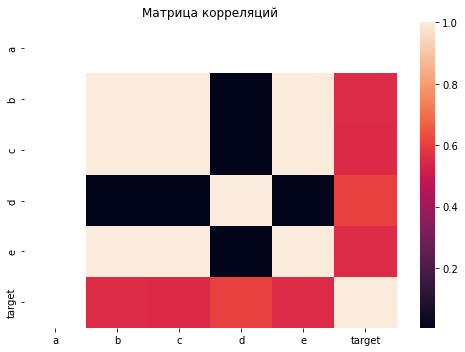

In [6]:
import seaborn as sns
corr = data.corr(method='spearman')

fig, ax = plt.subplots(figsize=(7,5))     
sns.heatmap(corr, ax=ax)
ax.set_title('Матрица корреляций');
plt.tight_layout()

Вывод: в данных скоррелированы столбцы b, c, e. Вообще, если бы было побольше данных, можно было бы оставить только столбцы a, b, d

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420, shuffle=True)

In [8]:
print(X_train.shape, y_train.shape)

(8000, 5) (8000, 1)


In [9]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

ИМХО градиент для MSE не такой, как подсказывают составители - нужно еще делить на N: 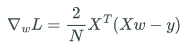

In [10]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()
    
    def forward(self, y_pred, y_true):

        loss_value = (y_true - y_pred).T @ (y_true - y_pred)     
        return loss_value[0] / len(y_pred)
    
    
    def backward(self, y_pred, y_true):

        partial_grad = 2 * (y_pred - y_true) / len(y_pred)
        return partial_grad

In [11]:
class linear_regression(Differentiable):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.theta = None
    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения целевой переменной
        return self.forward(X)
    
    def backward(self, X):

        partial_grad = X.T
        return partial_grad
    
    def forward(self, X):
        # этот метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        
        if (self.theta is None):
            # Если вектор параметров еще не инициализирован, его следует инициализировать
            # Подсказка: длина вектора параметров может быть получена из размера матрицы X
            self.theta = np.random.rand(X.shape[1], 1)
            
        y_pred = X @ self.theta
        return y_pred

Насколько я поняла, на семинарах были батчи, так что напишу с батчами...

In [12]:
def train_loop(X, y, model, loss_fn, batch_size, learning_rate, epochs=100):
    loss_history = []
    pbar = tqdm(total=epochs)
    
    for epoch in range(epochs):
        # В этом цикле следует реализовать итеративную процедуру оптимизации параметров модели model,
        #        руководствуясь функцией потерь loss_fn

        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)

        X = X[indices]
        y = y[indices]
        
        loss_value = np.zeros((X.shape[1], 1))

        for batch in range(len(X)//batch_size):
            start = batch * batch_size
            stop = (batch * batch_size) + batch_size

            X_batch = X[start:stop]
            y_batch = y[start:stop]
                
            y_pred = model.forward(X_batch)
            loss_value = loss_fn.forward(y_pred, y_batch)
            grad = model.backward(X_batch) @ loss_fn.backward(y_pred, y_batch)
            model.theta -= learning_rate * grad

        loss_history.append(loss_value)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value})
    pbar.close()
    return loss_history

In [13]:
obj_fn = loss()
lr_model = linear_regression()
loss_history = train_loop(X_train, y_train, lr_model, obj_fn, batch_size=400, learning_rate=0.00001, epochs=1000)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.37it/s, loss=[1.33402443]]


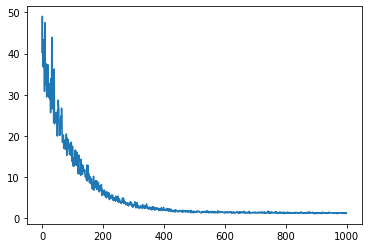

In [14]:
plt.plot(loss_history);

In [15]:
lr_model.theta

array([[ 0.482952  ],
       [-0.23478643],
       [-1.19351028],
       [ 0.50074366],
       [ 0.08102812]])

In [16]:
y_pred_test = lr_model.forward(X_test)
test_loss = obj_fn.forward(y_pred_test, y_test)
print(test_loss)

[1.25469875]


Вывод: наибольший вклад внесли признаки b, c, d. Лосс хороший, не превысил лосс на трейне.

Посмотрим результаты на другом размере батча

In [17]:
obj_fn = loss()
lr_model = linear_regression()
loss_history = train_loop(X_train, y_train, lr_model, obj_fn, batch_size=40, learning_rate=0.00001, epochs=1000)

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.01it/s, loss=[0.96093739]]


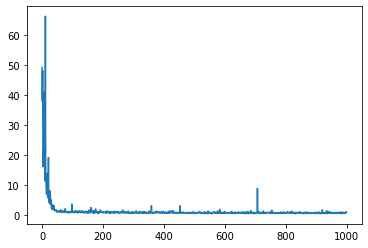

In [18]:
plt.plot(loss_history);

In [19]:
lr_model.theta

array([[-0.69750007],
       [-0.53126086],
       [-0.90907591],
       [ 0.52882544],
       [ 0.08233654]])

In [20]:
y_pred_test = lr_model.forward(X_test)
test_loss = obj_fn.forward(y_pred_test, y_test)
print(test_loss)

[0.65693293]


Вывод: меньший размер батча обеспечил более быстрое обучение модели и чуть лучший лосс, но принципиально и так было норм